## Transaction Data Visualisation

In [44]:
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.functions import lit, when
from pyspark.sql.functions import *

# Create a spark session
spark = (
    SparkSession.builder.appName("BNPL Project")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.driver.memory", "4g")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

### Load Dataset

In [3]:
dataset = spark.read.parquet("./../data/curated/part-00013-47f00a8c-554d-4703-b168-5eb79335c6d7-c000.snappy.parquet")

## Outliers

In [4]:
category = dataset.select('category').distinct()
for cat in category.collect():
    subset = dataset.filter(F.col("category") == cat[0])
    if (cat == 'retail_and_wholesale_trade'):
        subcategory = subset.select('subcategory').distinct()
        for subcat in subcategory.collect():
            sub = subset.filter(F.col("subcategory") == subcat[0])
            q3, q1 = sub.approxQuantile('dollar_value', [0.75, 0.25], 0) 
            iqr = q3 - q1
            min = q1 - 1.5*iqr
            max = q3 + 1.5*iqr

            if ('isOutlier' in dataset.columns):
                dataset = dataset.withColumn('isOutlier', 
                            when((dataset.subcategory == subcat[0]) & (dataset.dollar_value >= min) & (dataset.dollar_value <= max), lit('False'))\
                            .when((dataset.subcategory == subcat[0]), lit('True'))
                            .otherwise(dataset.isOutlier))
            else:
                dataset = dataset.withColumn('isOutlier', 
                            when((dataset.subcategory == subcat[0]) & (dataset.dollar_value >= min) & (dataset.dollar_value <= max), lit('False'))\
                            .when((dataset.subcategory == subcat[0]), lit('True')))
    else:
        q3, q1 = subset.approxQuantile('dollar_value', [0.75, 0.25], 0) 
        iqr = q3 - q1
        min = q1 - 1.5*iqr
        max = q3 + 1.5*iqr

        if ('isOutlier' in dataset.columns):
            dataset = dataset.withColumn('isOutlier', 
                        when((dataset.category == cat[0]) & (dataset.dollar_value >= min) & (dataset.dollar_value <= max), lit('False'))\
                        .when((dataset.category == cat[0]), lit('True'))
                        .otherwise(dataset.isOutlier))
        else:
            dataset = dataset.withColumn('isOutlier', 
                        when((dataset.category == cat[0]) & (dataset.dollar_value >= min) & (dataset.dollar_value <= max), lit('False'))\
                        .when((dataset.category == cat[0]), lit('True')))

dataset_wo_outliers = dataset.filter(F.col("isOutlier") == 'False')

In [5]:
dataset.limit(2)

merchant_abn,consumer_id,user_id,dollar_value,order_id,order_datetime,state,postcode,gender,merchant_name,tag,revenue,rate,category,subcategory,merchant_fraud_probability,user_fraud_probability,estimated_region_population_2021_sum,persons_earners_2018-19_sum,mean_earnings_2018-19_avg,sum_earnings_2018-19_sum,median_earnings_2018-19_avg,med_age_earners_2018-19_avg,isOutlier
10648956813,1194530,3,61.29,4d423d89-fa89-471...,2021-10-11,NT,862,Female,Proin Nisl Institute,"computers, comput...",a,6.66,retail_and_wholes...,household_goods_r...,null,0.08,null,null,null,null,null,null,False
18303734841,1194530,3,265.44,6bd12e7e-e625-429...,2022-02-18,NT,862,Female,Sollicitudin Orci...,health and beauty...,a,6.61,others,null,null,0.08,null,null,null,null,null,null,False


In [45]:
q3, q1 = dataset_wo_outliers.approxQuantile('dollar_value', [0.75, 0.25], 0) 
iqr = q3 - q1
min = q1 - 1.5*iqr
max = q3 + 1.5*iqr
final_dataset = dataset_wo_outliers.filter((F.col("estimated_region_population_2021_sum") >= min) & 
                                            (F.col("estimated_region_population_2021_sum") <= max))
final_dataset = final_dataset.withColumn('order_datetime', to_timestamp('order_datetime'))

## Distributions of Variables with and without Outliers

In [26]:
import seaborn as sns
from matplotlib import pyplot as plt 

In [46]:
dataset_df = dataset.toPandas()
dataset_wo_outliers_df = dataset_wo_outliers.toPandas()
final_dataset_df = final_dataset.toPandas()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


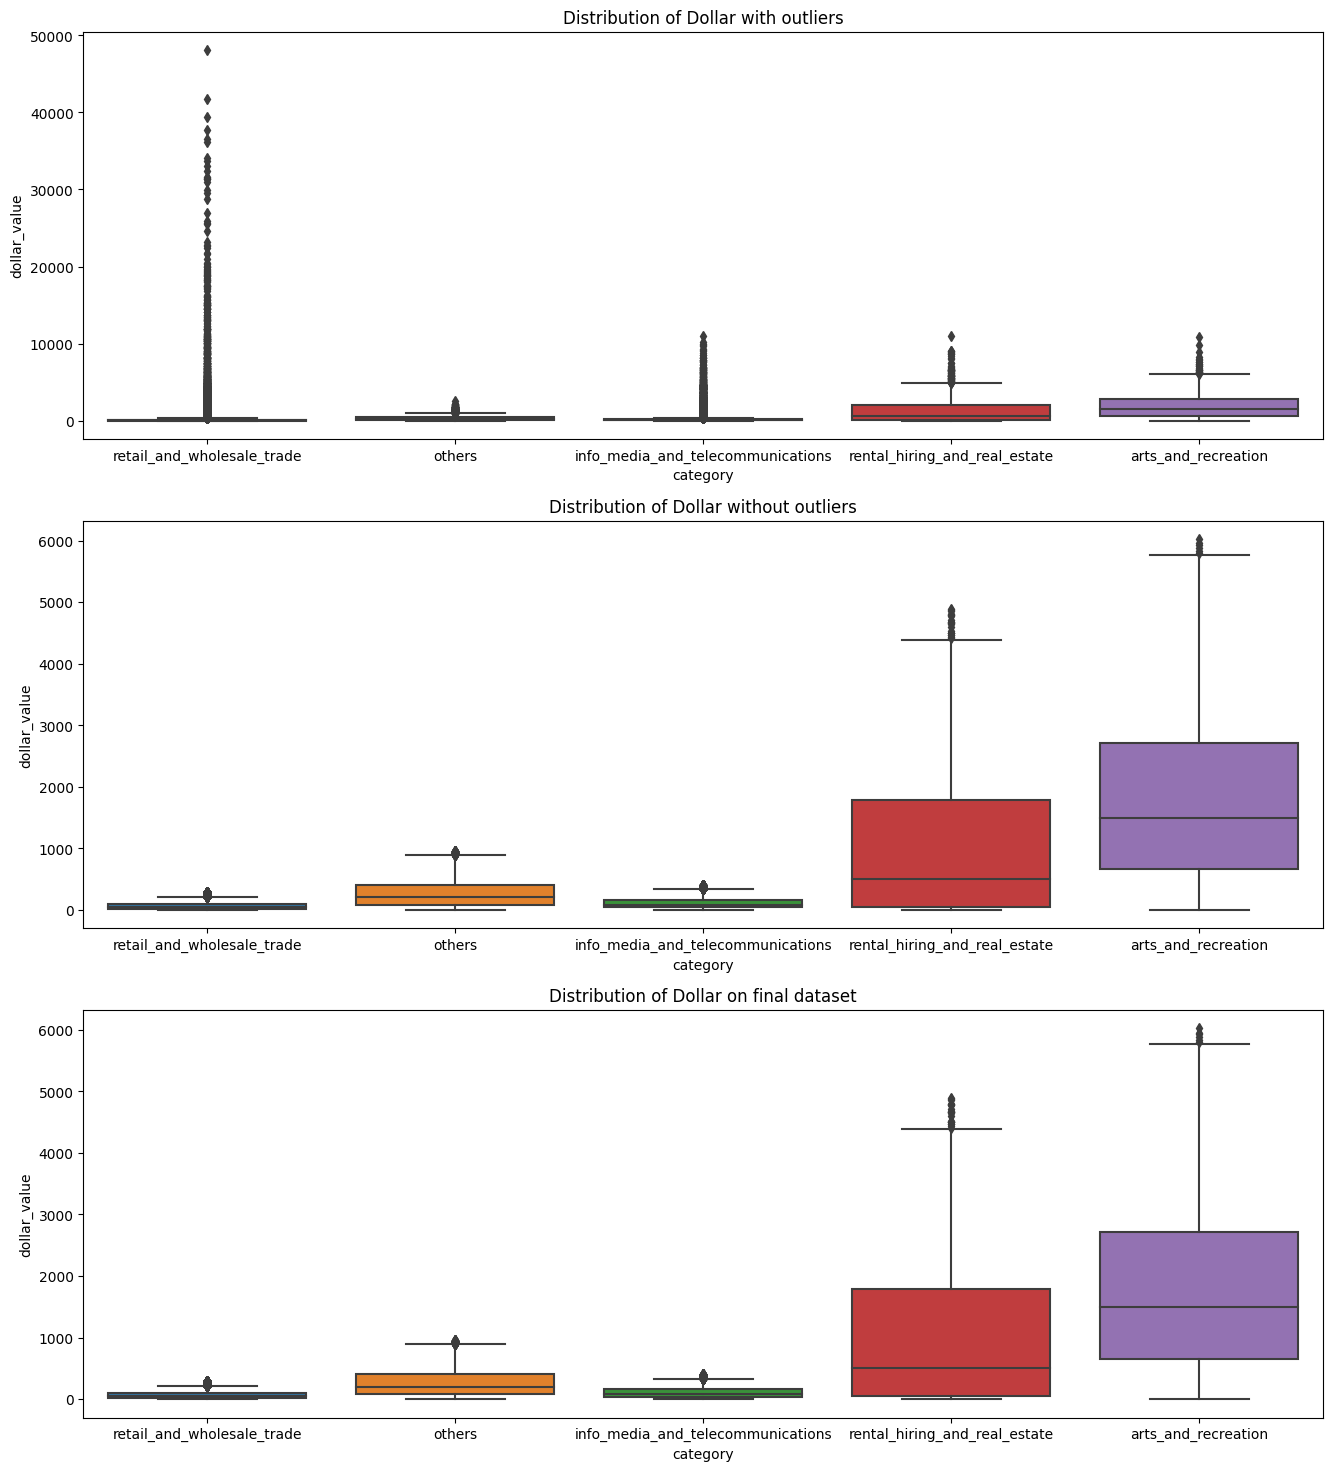

In [59]:
fig, axes = plt.subplots(3, 1, figsize=(16,18))

boxplot = sns.boxplot(ax= axes[0], data=dataset_df, x="category", y="dollar_value").set(title = 'Distribution of Dollar with outliers')
boxplot2 = sns.boxplot(ax= axes[1], data=dataset_wo_outliers_df, x="category", y="dollar_value").set(title = 'Distribution of Dollar without outliers')
boxplot3 = sns.boxplot(ax= axes[2], data=dataset_wo_outliers_df, x="category", y="dollar_value").set(title = 'Distribution of Dollar on final dataset')

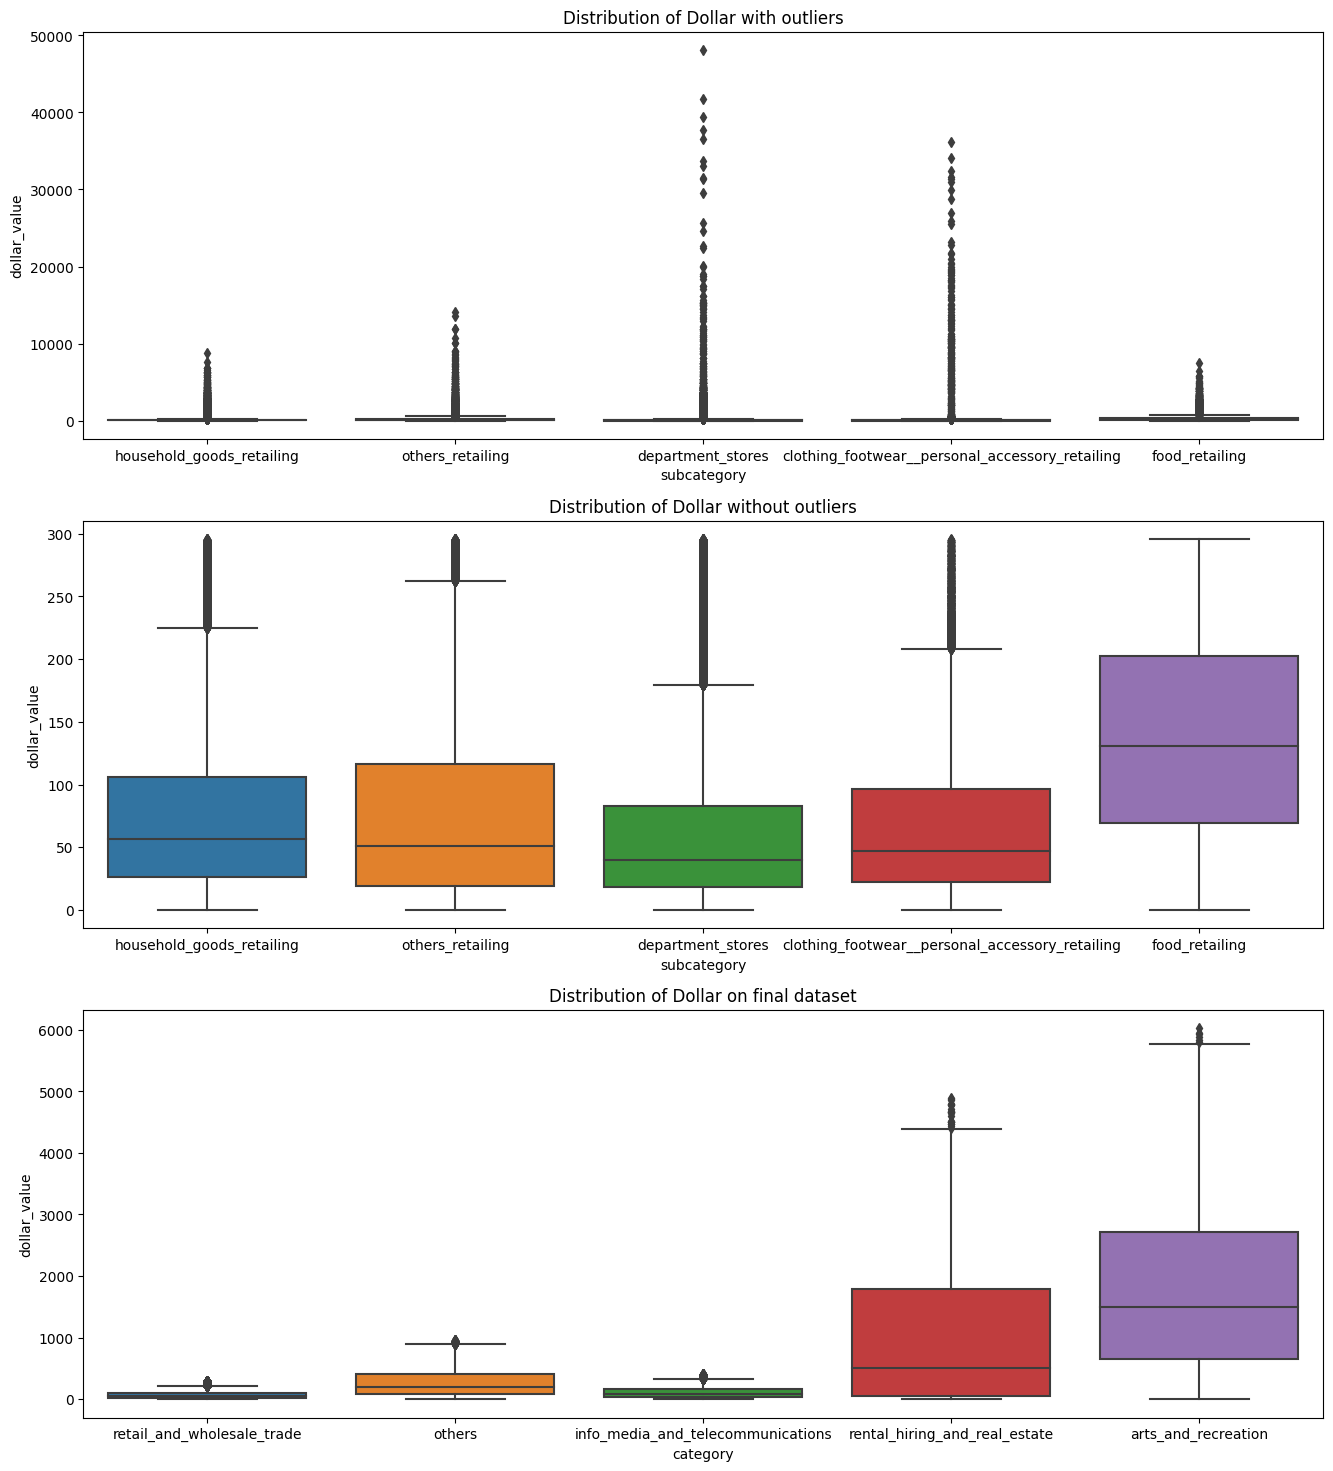

In [60]:
fig, axes = plt.subplots(3, 1, figsize=(16,18))

boxplot = sns.boxplot(ax= axes[0], data=dataset_df, x="subcategory", y="dollar_value").set(title = 'Distribution of Dollar with outliers')
boxplot2 = sns.boxplot(ax= axes[1], data=dataset_wo_outliers_df, x="subcategory", y="dollar_value").set(title = 'Distribution of Dollar without outliers')
boxplot3 = sns.boxplot(ax= axes[2], data=dataset_wo_outliers_df, x="category", y="dollar_value").set(title = 'Distribution of Dollar on final dataset')

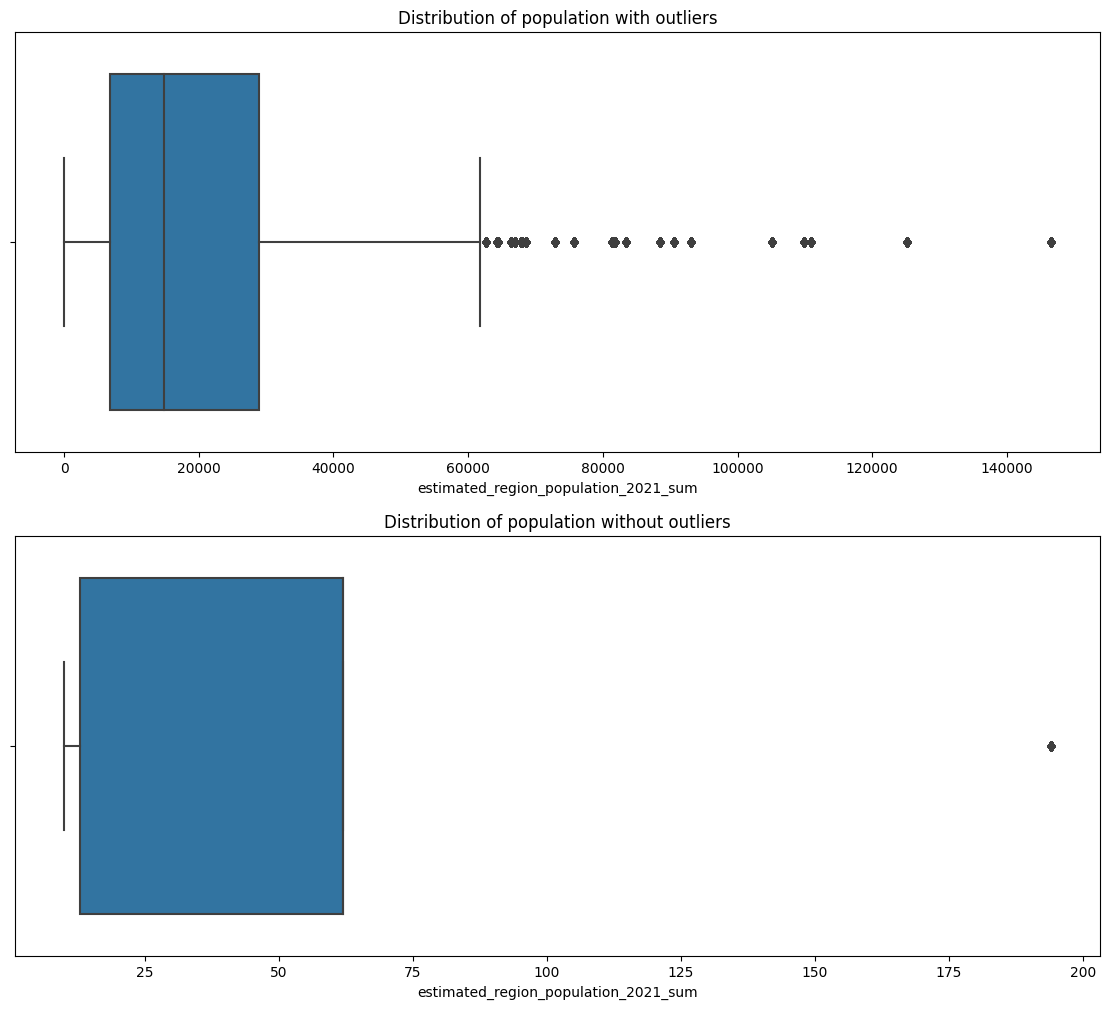

In [36]:
fig, axes = plt.subplots(2, 1, figsize=(14,12))

boxplot = sns.boxplot(ax= axes[0], data=dataset_wo_outliers_df, x="estimated_region_population_2021_sum").set(title = 'Distribution of population with outliers')
boxplot2 = sns.boxplot(ax= axes[1], data=final_dataset_df, x="estimated_region_population_2021_sum").set(title = 'Distribution of population without outliers')

## Relationship between Features

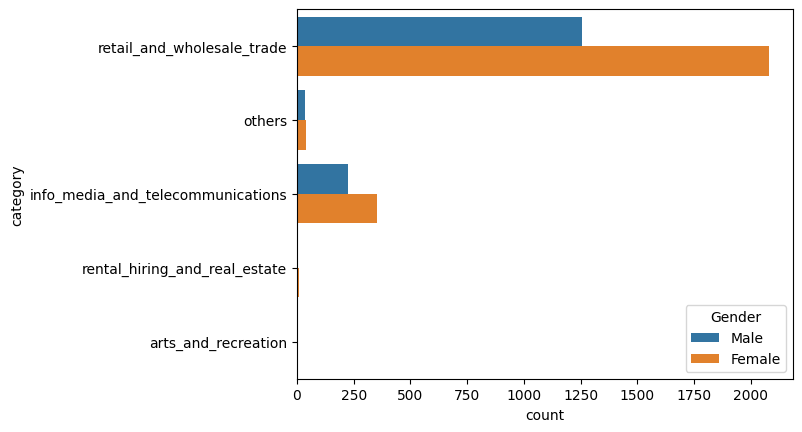

In [38]:
sns.countplot(data= final_dataset_df, y="category", hue="gender").legend(loc='lower right', title='Gender')

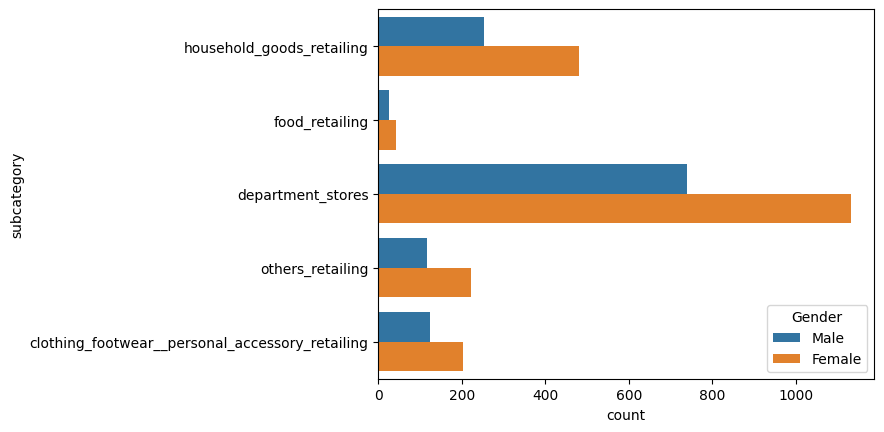

In [39]:
sns.countplot(data= final_dataset_df, y="subcategory", hue="gender").legend(loc='lower right', title='Gender')

<AxesSubplot: xlabel='order_datetime', ylabel='Density'>

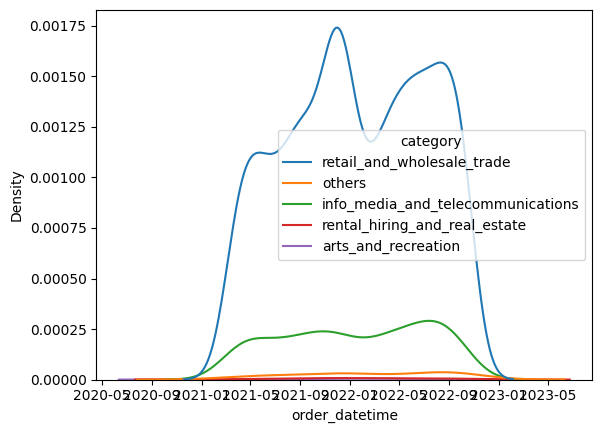

In [53]:
sns.kdeplot(data=final_dataset_df, x="order_datetime", hue="category")

<AxesSubplot: xlabel='order_datetime', ylabel='Density'>

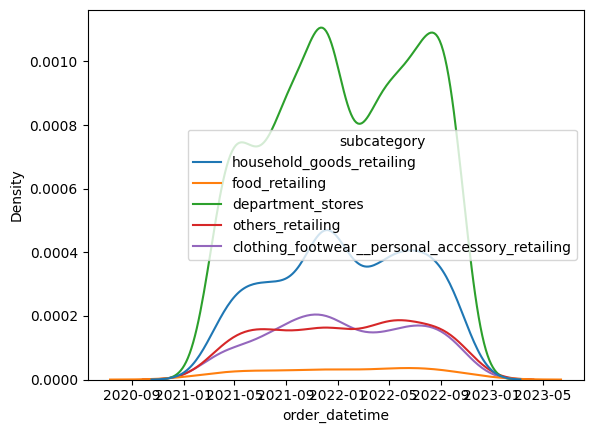

In [54]:
sns.kdeplot(data=final_dataset_df, x="order_datetime", hue="subcategory")

<AxesSubplot: xlabel='state', ylabel='dollar_value'>

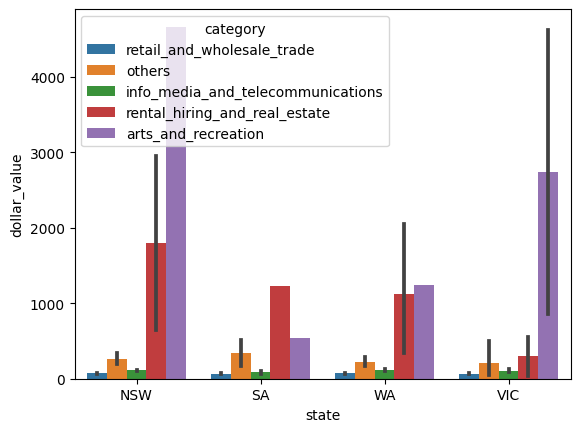

In [57]:
sns.barplot(data=final_dataset_df, x="state", y="dollar_value", hue="category")

<AxesSubplot: xlabel='state', ylabel='dollar_value'>

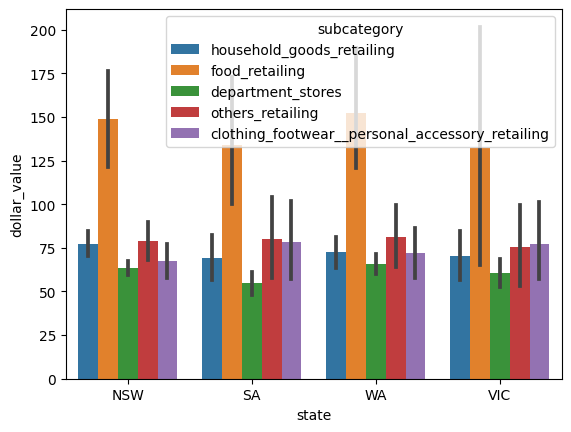

In [58]:
sns.barplot(data=final_dataset_df, x="state", y="dollar_value", hue="subcategory")